In [1]:
import trenchripper as tr

import csv
import copy
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import pickle as pkl

from Bio import SeqIO
from Bio.Seq import Seq

from matplotlib import pyplot as plt

dask_wd = "/home/de64/scratch/de64/dask"

## Figure S1A

In [2]:
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

In [3]:
R9_data = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE11_Sequencing/lDE11_R9_df.tsv", sep="\t")
R10_data = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE11_Sequencing/lDE11_R10_df.tsv", sep="\t")

## compute calls
R9_ground_truth_data = R9_data[R9_data["subsample"]==200]
R9_ground_truth_lookup = dict(zip(R9_ground_truth_data["barcodeid"],R9_ground_truth_data["dark_gfp"]))

R9_data["GFP Call"] = R9_data.apply(lambda x: x["dark_gfp"]==R9_ground_truth_lookup[x["barcodeid"]],axis=1)

R10_ground_truth_data = R10_data[R10_data["subsample"]==200]
R10_ground_truth_lookup = dict(zip(R10_ground_truth_data["barcodeid"],R10_ground_truth_data["dark_gfp"]))

R10_data["GFP Call"] = R10_data.apply(lambda x: x["dark_gfp"]==R10_ground_truth_lookup[x["barcodeid"]],axis=1)

R9_subsample_group = R9_data.groupby("subsample")
R10_subsample_group = R10_data.groupby("subsample")

R9_GFP_call_curve = 1-R9_subsample_group.aggregate({'GFP Call': 'mean'})
R10_GFP_call_curve = 1-R10_subsample_group.aggregate({'GFP Call': 'mean'})

R9_GFP_q_scores = -10*np.log10(R9_GFP_call_curve)
R10_GFP_q_scores = -10*np.log10(R10_GFP_call_curve)

R9_ground_truth_umi_lookup = dict(zip(R9_ground_truth_data["barcodeid"],R9_ground_truth_data["UMI"]))
R9_data["UMI Errors"] = R9_data.apply(lambda x: hamming_distance(x["UMI"],R9_ground_truth_umi_lookup[x["barcodeid"]]),axis=1)
R9_data["UMI Error Rate"] = R9_data["UMI Errors"]/15
R9_subsample_group = R9_data.groupby("subsample")
R9_UMI_call_curve = R9_subsample_group.aggregate({'UMI Error Rate': 'mean'})

R10_ground_truth_umi_lookup = dict(zip(R10_ground_truth_data["barcodeid"],R10_ground_truth_data["UMI"]))
R10_data["UMI Errors"] = R10_data.apply(lambda x: hamming_distance(x["UMI"],R10_ground_truth_umi_lookup[x["barcodeid"]]),axis=1)
R10_data["UMI Error Rate"] = R10_data["UMI Errors"]/15
R10_subsample_group = R10_data.groupby("subsample")
R10_UMI_call_curve = R10_subsample_group.aggregate({'UMI Error Rate': 'mean'})

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


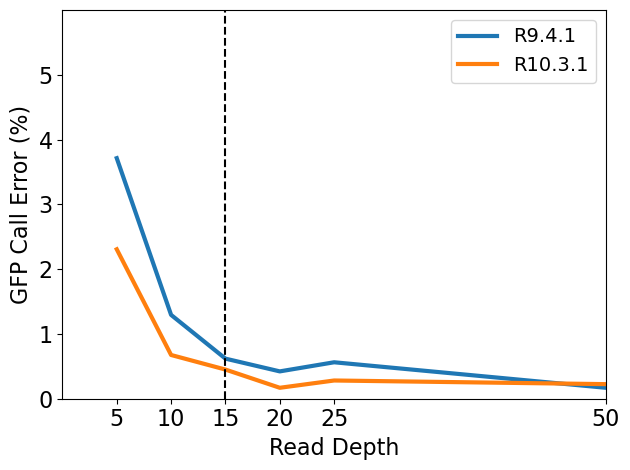

In [17]:
plt.plot(R9_GFP_call_curve*100,linewidth=3.,label="R9.4.1")
plt.plot(R10_GFP_call_curve*100,linewidth=3.,label="R10.3.1")
plt.axvline(15,color="C1",ls="--",c="black")
plt.ylim(0.,6.)
plt.xlim(0,50)
plt.xticks([5,10,15,20,25,50],fontsize=16)
plt.yticks([0.,1.,2.,3.,4.,5.],fontsize=16)
plt.xlabel("Read Depth",fontsize=16)
plt.ylabel("GFP Call Error (%)",fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/Figure_S1_1.png",dpi=300)

## Figure S1B

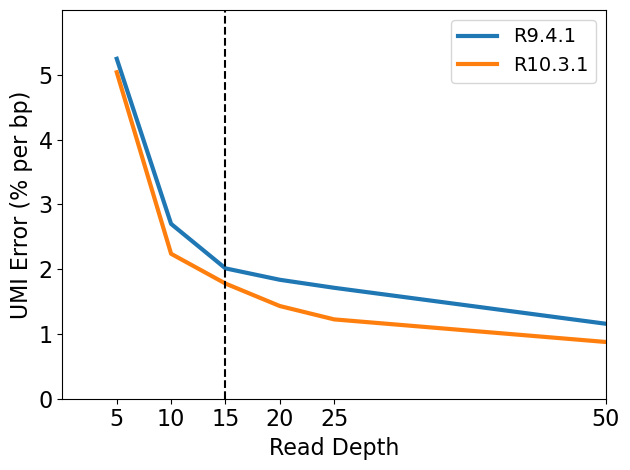

In [18]:
plt.plot(R9_UMI_call_curve*100,linewidth=3.,label="R9.4.1")
plt.plot(R10_UMI_call_curve*100,linewidth=3.,label="R10.3.1")
plt.axvline(15,color="C1",ls="--",c="black")
plt.ylim(0.,6.)
plt.xlim(0,50)
plt.xticks([5,10,15,20,25,50],fontsize=16)
plt.yticks([0.,1.,2.,3.,4.,5.],fontsize=16)
plt.xlabel("Read Depth",fontsize=16)
plt.ylabel("UMI Error (% per bp)",fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/Figure_S1_2.png",dpi=300)

## Figures S1C

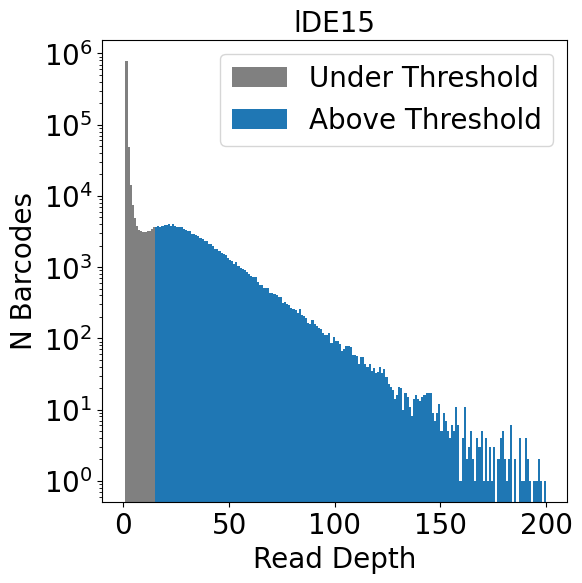

In [12]:
with open('/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE15_Sequencing/barcode_counts_dict.pkl', 'rb') as infile:
    depth_dict = pkl.load(infile)

depth_arr = np.array(list(depth_dict.values()))

fig = plt.figure(figsize=(6, 6))

threshold=15

under_threshold_arr = depth_arr[depth_arr<threshold]
above_threshold_arr = depth_arr[depth_arr>=threshold]
plt.hist(under_threshold_arr, bins=200, range=(0,200), log=True, color="grey", label="Under Threshold")
plt.hist(above_threshold_arr, bins=200, range=(0,200), log=True, color="tab:blue", label="Above Threshold")
plt.xlabel("Read Depth",fontsize=20)
plt.xticks([0,50,100,150,200],fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title("lDE15",fontsize=20)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE15_Depth_Distribution.png",dpi=300,bbox_inches="tight")

## Figures S1D

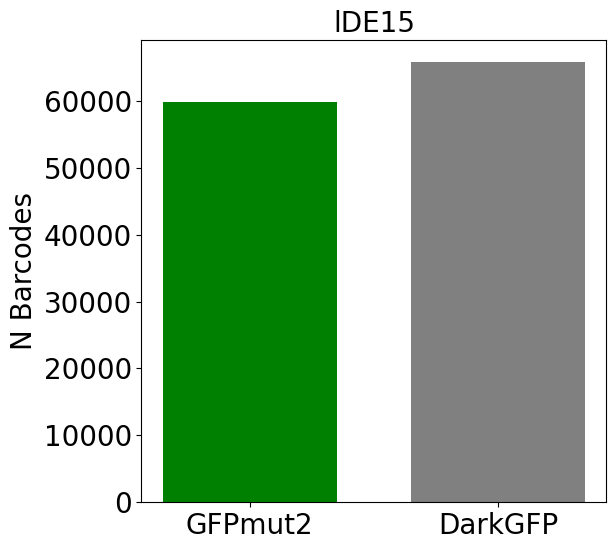

In [13]:
data_df = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE15_Sequencing/lDE15_final_df.tsv",sep="\t")

GFP_freq = np.unique(data_df["dark_gfp"],return_counts=True)[1]/data_df["dark_gfp"].size

n_gfp = np.sum(~data_df["dark_gfp"])
n_dark = np.sum(data_df["dark_gfp"])

fig = plt.figure(figsize=(6, 6))

plt.bar([0,1],[n_gfp,n_dark],color=["green","grey"],width=0.7)
plt.xticks(ticks=[0,1],labels=["GFPmut2","DarkGFP"],fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.title("lDE15",fontsize=20)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/barcodes_per_gfp.png",dpi=300,bbox_inches="tight")

## Figures S1E

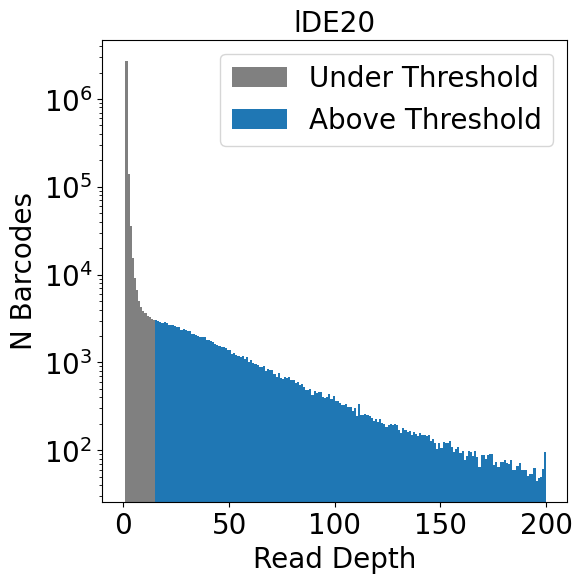

In [6]:
with open('/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/barcode_counts_dict.pkl', 'rb') as infile:
    depth_dict = pkl.load(infile)

depth_arr = np.array(list(depth_dict.values()))

fig = plt.figure(figsize=(6, 6))

threshold=15

under_threshold_arr = depth_arr[depth_arr<threshold]
above_threshold_arr = depth_arr[depth_arr>=threshold]
plt.hist(under_threshold_arr, bins=200, range=(0,200), log=True, color="grey", label="Under Threshold")
plt.hist(above_threshold_arr, bins=200, range=(0,200), log=True, color="tab:blue", label="Above Threshold")
plt.xlabel("Read Depth",fontsize=20)
plt.xticks([0,50,100,150,200],fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title("lDE20",fontsize=20)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE20_Depth_Distribution.png",dpi=300,bbox_inches="tight")

## Figures S1F

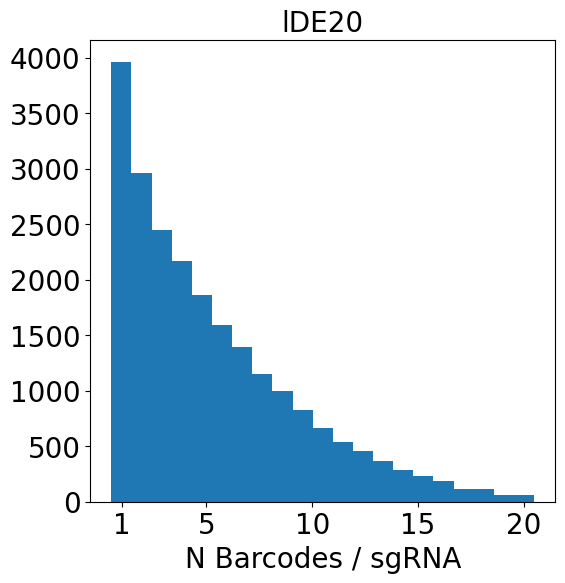

In [8]:
merged_df = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/lDE20_final_df.tsv",sep="\t")

n_barcodes = merged_df.groupby("sgRNA").size()#[101:]

fig = plt.figure(figsize=(6, 6))

plt.hist(n_barcodes, bins=21, range=(1,21), log=False)
plt.xlabel("N Barcodes / sgRNA",fontsize=20)
plt.xticks(ticks=[1.5,5.5,10.5,15.5,20.5],labels=["1","5","10","15","20"],fontsize=20)
plt.yticks(fontsize=20)
plt.title("lDE20",fontsize=20)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/barcodes_per_sgrna.png",dpi=300,bbox_inches="tight")
plt.show()

## Figures S1G

In [31]:
lDE20_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
lDE20_design = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Sequencing/2021-04-20_Essential_KO_Lib_df_coords_corrected.tsv",sep="\t")

lDE20_ss_estimators_df = lDE20_ss_estimators_df.loc["Mean (Robust)"]
final_column_df = lDE20_ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[["Gene","Category"]]
lDE20_ss_estimators_df["SEM/Location"] = (np.sqrt(lDE20_ss_estimators_df["Estimator Variance"])/lDE20_ss_estimators_df["Value"]).copy()
lDE20_ss_estimators_df = lDE20_ss_estimators_df.reset_index().set_index("oDEPool7_id")

##hack to get both observations and proliferating observations (was broken)
observation_df = lDE20_ss_estimators_df[lDE20_ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(lDE20_ss_estimators_df[lDE20_ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

lDE20_ss_estimators_df = lDE20_ss_estimators_df[["Variable(s)","Value"]]
lDE20_ss_estimators_df = lDE20_ss_estimators_df.pivot(columns=["Variable(s)"])
lDE20_ss_estimators_df.columns = lDE20_ss_estimators_df.columns.droplevel(0)
lDE20_ss_estimators_df = lDE20_ss_estimators_df.join(observation_df,on='oDEPool7_id')
lDE20_ss_estimators_df = lDE20_ss_estimators_df.join(final_column_df)

lDE20_n_obs_barcodes = lDE20_ss_estimators_df.groupby("oDEPool7_id",sort=False)["N Observations"].sum().astype(int)
lDE20_design_no_controls = lDE20_design[lDE20_design["Category"]=='Target']
lDE20_n_obs_barcodes_df = lDE20_design_no_controls[["oDEPool7_id","Gene"]].set_index("oDEPool7_id")
lDE20_n_obs_barcodes_df["N Observations"] = lDE20_n_obs_barcodes
lDE20_n_obs_barcodes_df.loc[np.isnan(lDE20_n_obs_barcodes_df["N Observations"]),"N Observations"] = 0
lDE20_n_obs_sgrna = lDE20_n_obs_barcodes_df["N Observations"]

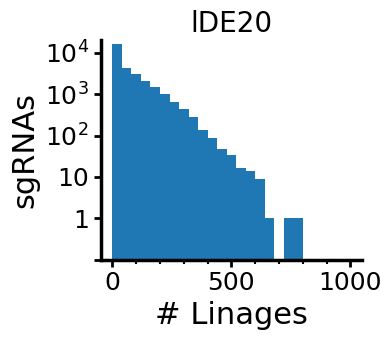

In [32]:
max_allowed_sgrna_val = 1000

plt.figure(figsize=(4,3.5))

ax = plt.subplot(1,1,1)
ax.set_title("lDE20",fontsize=20)
ax.minorticks_on()
ax.set_xlabel("# Linages",fontsize=22)
ax.set_ylabel("sgRNAs",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
n_obs_sgrna_clipped = np.clip(lDE20_n_obs_sgrna,0,max_allowed_sgrna_val)
ax.hist(n_obs_sgrna_clipped,range=(0,max_allowed_sgrna_val),bins=25,log=True)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_ylim(0.1,20000)
ax.set_yticks([0.1,1,10,100,1000,10000],labels=["","1","10",r"$10^{2}$",r"$10^{3}$",r"$10^{4}$"])
sns.despine()

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE20_Variant_Coverage_sgRNA_Only.png",transparent=True,dpi=500,bbox_inches="tight")

## Figures S1H

In [33]:
lDE26_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
lDE28_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE28_Imaging/2024-02-26_lDE28_Steady_State_df_Estimators_wStats.pkl")
lDE30_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE30_Imaging/2024-02-26_lDE30_Steady_State_df_Estimators_wStats.pkl")
lDE26_design = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Sequencing/2023-02-03_Nucleoid_Screen_Design_V2.tsv",sep="\t")

lDE26_ss_estimators_df = lDE26_ss_estimators_df.loc["Mean (Robust)"]
final_column_df = lDE26_ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[["Gene","Category"]]
lDE26_ss_estimators_df["SEM/Location"] = (np.sqrt(lDE26_ss_estimators_df["Estimator Variance"])/lDE26_ss_estimators_df["Value"]).copy()
lDE26_ss_estimators_df = lDE26_ss_estimators_df.reset_index().set_index("oDEPool7_id")

##hack to get both observations and proliferating observations (was broken)
observation_df = lDE26_ss_estimators_df[lDE26_ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(lDE26_ss_estimators_df[lDE26_ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

lDE26_ss_estimators_df = lDE26_ss_estimators_df[["Variable(s)","Value"]]
lDE26_ss_estimators_df = lDE26_ss_estimators_df.pivot(columns=["Variable(s)"])
lDE26_ss_estimators_df.columns = lDE26_ss_estimators_df.columns.droplevel(0)
lDE26_ss_estimators_df = lDE26_ss_estimators_df.join(observation_df,on='oDEPool7_id')
lDE26_ss_estimators_df = lDE26_ss_estimators_df.join(final_column_df)

lDE26_n_obs_barcodes = lDE26_ss_estimators_df.groupby("oDEPool7_id",sort=False)["N Observations"].sum().astype(int)
lDE26_design_no_controls = lDE26_design[lDE26_design["Category"]=='Target']
lDE26_n_obs_barcodes_df = lDE26_design_no_controls[["oDEPool7_id","Gene"]].set_index("oDEPool7_id")
lDE26_n_obs_barcodes_df["N Observations"] = lDE26_n_obs_barcodes
lDE26_n_obs_barcodes_df.loc[np.isnan(lDE26_n_obs_barcodes_df["N Observations"]),"N Observations"] = 0
lDE26_n_obs_sgrna = lDE26_n_obs_barcodes_df["N Observations"]

lDE28_ss_estimators_df = lDE28_ss_estimators_df.loc["Mean (Robust)"]
final_column_df = lDE28_ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[["Gene","Category"]]
lDE28_ss_estimators_df["SEM/Location"] = (np.sqrt(lDE28_ss_estimators_df["Estimator Variance"])/lDE28_ss_estimators_df["Value"]).copy()
lDE28_ss_estimators_df = lDE28_ss_estimators_df.reset_index().set_index("oDEPool7_id")

##hack to get both observations and proliferating observations (was broken)
observation_df = lDE28_ss_estimators_df[lDE28_ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(lDE28_ss_estimators_df[lDE28_ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

lDE28_ss_estimators_df = lDE28_ss_estimators_df[["Variable(s)","Value"]]
lDE28_ss_estimators_df = lDE28_ss_estimators_df.pivot(columns=["Variable(s)"])
lDE28_ss_estimators_df.columns = lDE28_ss_estimators_df.columns.droplevel(0)
lDE28_ss_estimators_df = lDE28_ss_estimators_df.join(observation_df,on='oDEPool7_id')
lDE28_ss_estimators_df = lDE28_ss_estimators_df.join(final_column_df)

lDE28_n_obs_barcodes = lDE28_ss_estimators_df.groupby("oDEPool7_id",sort=False)["N Observations"].sum().astype(int)
lDE28_design_no_controls = lDE26_design[lDE26_design["Category"]=='Target']
lDE28_n_obs_barcodes_df = lDE28_design_no_controls[["oDEPool7_id","Gene"]].set_index("oDEPool7_id")
lDE28_n_obs_barcodes_df["N Observations"] = lDE28_n_obs_barcodes
lDE28_n_obs_barcodes_df.loc[np.isnan(lDE28_n_obs_barcodes_df["N Observations"]),"N Observations"] = 0
lDE28_n_obs_sgrna = lDE28_n_obs_barcodes_df["N Observations"]

lDE30_ss_estimators_df = lDE30_ss_estimators_df.loc["Mean (Robust)"]
final_column_df = lDE30_ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[["Gene","Category"]]
lDE30_ss_estimators_df["SEM/Location"] = (np.sqrt(lDE30_ss_estimators_df["Estimator Variance"])/lDE30_ss_estimators_df["Value"]).copy()
lDE30_ss_estimators_df = lDE30_ss_estimators_df.reset_index().set_index("oDEPool7_id")

##hack to get both observations and proliferating observations (was broken)
observation_df = lDE30_ss_estimators_df[lDE30_ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(lDE30_ss_estimators_df[lDE30_ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

lDE30_ss_estimators_df = lDE30_ss_estimators_df[["Variable(s)","Value"]]
lDE30_ss_estimators_df = lDE30_ss_estimators_df.pivot(columns=["Variable(s)"])
lDE30_ss_estimators_df.columns = lDE30_ss_estimators_df.columns.droplevel(0)
lDE30_ss_estimators_df = lDE30_ss_estimators_df.join(observation_df,on='oDEPool7_id')
lDE30_ss_estimators_df = lDE30_ss_estimators_df.join(final_column_df)

lDE30_n_obs_barcodes = lDE30_ss_estimators_df.groupby("oDEPool7_id",sort=False)["N Observations"].sum().astype(int)
lDE30_design_no_controls = lDE26_design[lDE26_design["Category"]=='Target']
lDE30_n_obs_barcodes_df = lDE30_design_no_controls[["oDEPool7_id","Gene"]].set_index("oDEPool7_id")
lDE30_n_obs_barcodes_df["N Observations"] = lDE30_n_obs_barcodes
lDE30_n_obs_barcodes_df.loc[np.isnan(lDE30_n_obs_barcodes_df["N Observations"]),"N Observations"] = 0
lDE30_n_obs_sgrna = lDE30_n_obs_barcodes_df["N Observations"]

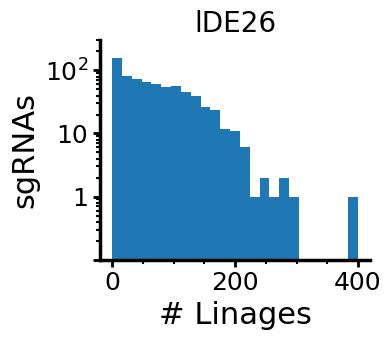

In [35]:
plt.figure(figsize=(4,3.5))

max_allowed_sgrna_val = 400

ax = plt.subplot(1,1,1)
ax.set_title("lDE26",fontsize=20)
ax.minorticks_on()
ax.set_xlabel("# Linages",fontsize=22)
ax.set_ylabel("sgRNAs",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
n_obs_sgrna_clipped = np.clip(lDE26_n_obs_sgrna,0,max_allowed_sgrna_val)
ax.hist(n_obs_sgrna_clipped,range=(0,max_allowed_sgrna_val),bins=25,log=True)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_ylim(0.1,300)
ax.set_yticks([0.1,1,10,100],labels=["","1","10",r"$10^{2}$"])
sns.despine()

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE26_Variant_Coverage_sgRNA_only.png",transparent=True,dpi=500,bbox_inches="tight")

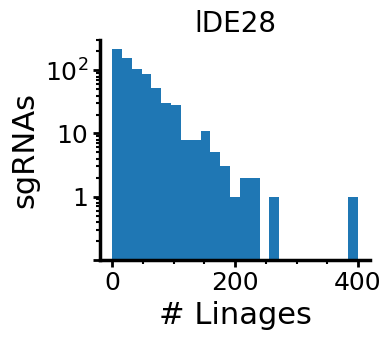

In [37]:
plt.figure(figsize=(4,3.5))

max_allowed_sgrna_val = 400

ax = plt.subplot(1,1,1)
ax.set_title("lDE28",fontsize=20)
ax.minorticks_on()
ax.set_xlabel("# Linages",fontsize=22)
ax.set_ylabel("sgRNAs",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
n_obs_sgrna_clipped = np.clip(lDE28_n_obs_sgrna,0,max_allowed_sgrna_val)
ax.hist(n_obs_sgrna_clipped,range=(0,max_allowed_sgrna_val),bins=25,log=True)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_ylim(0.1,300)
ax.set_yticks([0.1,1,10,100],labels=["","1","10",r"$10^{2}$"])
sns.despine()

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE28_Variant_Coverage_sgRNA_only.png",transparent=True,dpi=500,bbox_inches="tight")

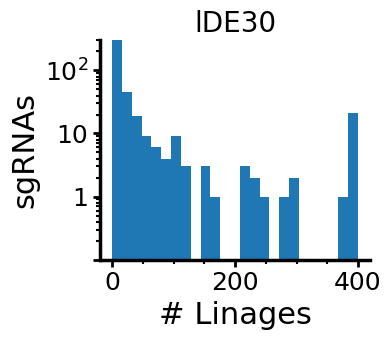

In [38]:
plt.figure(figsize=(4,3.5))

max_allowed_sgrna_val = 400

ax = plt.subplot(1,1,1)
ax.set_title("lDE30",fontsize=20)
ax.minorticks_on()
ax.set_xlabel("# Linages",fontsize=22)
ax.set_ylabel("sgRNAs",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
n_obs_sgrna_clipped = np.clip(lDE30_n_obs_sgrna,0,max_allowed_sgrna_val)
ax.hist(n_obs_sgrna_clipped,range=(0,max_allowed_sgrna_val),bins=25,log=True)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_ylim(0.1,300)
ax.set_yticks([0.1,1,10,100],labels=["","1","10",r"$10^{2}$"])
sns.despine()

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE30_Variant_Coverage_sgRNA_only.png",transparent=True,dpi=500,bbox_inches="tight")

## Figures S1I

#### Adding Growth Slope Filters

In [3]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

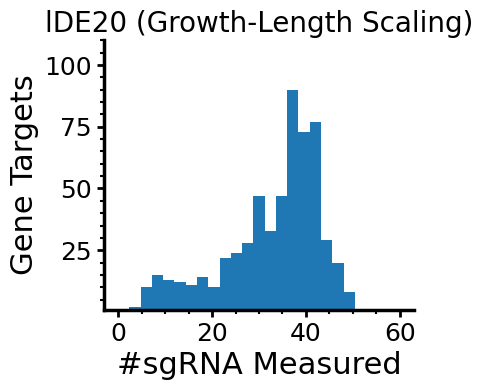

In [5]:
n_points_per_gene = ss_estimators_df.groupby("Gene").size()

plt.figure(figsize=(4,3.5))
ax = plt.subplot(1,1,1)
ax.set_title("lDE20 (Growth-Length Scaling)",fontsize=20)
ax.minorticks_on()
ax.set_xlabel("#sgRNA Measured",fontsize=22)
ax.set_ylabel("Gene Targets",fontsize=22)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
ax.hist(n_points_per_gene,range=(0,60),bins=25,log=False)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_ylim(1,110)
sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S1/lDE20_Variant_Coverage_Growth_Scaling.png",transparent=True,dpi=500,bbox_inches="tight")